# Summary
This notebook contains the regularized iterative hard smoothing for a SBM with average_node_degree = 42,
and lambda_block_parameter = 1.2. Each class has 500 nodes (Figure 4 (a), upper right).

## load Libraries

In [1]:
from __future__ import division
import sys
print(sys.version)
import os
#import igraph
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats.kde import gaussian_kde
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter
from mpl_toolkits.axes_grid1 import Grid
from scipy.stats import bernoulli

import networkx as nx

import numpy as np

from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import itertools

from numpy.linalg import inv

## function to create + save dictionary of features
def create_dict(key, obj):
    return(dict([(key[i], obj[i]) for i in range(len(key))]))

3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## load helper functions 

In [15]:
# set the working directory and import helper functions
#get the current working directory and then redirect into the functions under code 
cwd = os.getcwd()

# parents working directory of the current directory: which is the code folder
parent_cwd = os.path.dirname(cwd)
# get into the functions folder
functions_cwd = parent_cwd + '/functions'
# change the working directory to be .../functions
os.chdir(functions_cwd)

# import all helper functions
exec(open('ZGL.py').read())
exec(open('iterative_method_ZGL_regularized_SBM.py').read())
exec(open('create_expected_degree_sequence.py').read())
exec(open('create_proportion_class_k_friends.py').read())
exec(open('create_affiliation_model_temp.py').read())


def in_class_matrix(matrix):
    return(matrix.T*matrix)

def out_class_matrix(matrix1,matrix2):
    return(matrix1.T*matrix2)

## create a SBM model

In [16]:
# create a SBM model
(adj_noBnoO_osbm, y_noBnoO_osbm) =  create_affiliation_model_temp(42,
                                          lambda_block_parameter = 1.2,
                                          dispersion_parameter_vect = np.array([np.array([0, 0]),
                                            np.array([0, 0])]), 
                                          class_size_vect = np.array([500,500]))

##########################################################################
graph = nx.from_numpy_matrix(adj_noBnoO_osbm)
gender_y = y_noBnoO_osbm

## general setup

In [17]:
percent_initially_unlabelled = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05] 
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled) 
n_iter = 10
cv_setup ='stratified'

mean_accuracy = []
se_accuracy = []

mean_micro_auc = []
se_micro_auc = []

mean_wt_auc = []
se_wt_auc = []


n = len(gender_y)
keys = list(graph.node)


# see how many classes are there and rearrange them
classes = np.sort(np.unique(gender_y))
class_labels = np.array(range(len(classes)))


# relabel membership class labels - for coding convenience
# preserve ordering of original class labels -- but force to be in sequential order now
gender_y_update = np.copy(gender_y)
for j in range(len(classes)):
    gender_y_update[gender_y_update == classes[j]] = class_labels[j]

gender_y_update = np.array(gender_y_update)

## regularized iterative hard smoothing update (regularized iterative ZGL)

In [18]:
# regularized version of iterative hard smoothing method(ZGL) for SBM 
# consider across whole dataset not just the non-NA for the first iterations
def iterative_method_ZGL_regularized_SBM(t, G, gender_y_update, theta0, train_index, test_index):
    A = np.array(nx.adjacency_matrix(G).todense()) 
    D = np.diag(np.sum(A, axis=1))
    d = np.diag(D)
    theta = [None]*len(theta0)
    theta0 = np.array(theta0)
    
    accuracy =  [] 
    micro_auc = []
    wt_auc = []
    
    accuracy_score_benchmark = np.sum(theta0[train_index])/len(train_index)
    ratio = len(train_index)/len(gender_y_update)
    for j in train_index:
        theta[j] = theta0[j]
    if t ==1:
        # test_index_non_na is used to hold test nodes whose two-hops labeled neighbors are not empty
        #test_index_non_na = []
        for j in test_index:
        # if it is the first iteration, which is reduced to the 2-hop method
            # update theta[j] according to the 2-hop update rule
            # get j's neighbor
            denom = 0
            nom = 0
            j_neighbor = list(G.neighbors(j)) 
            train_set = np.array(train_index)
             
            one_hop_neighbor = []
            one_hop_neighbor = [i for i in j_neighbor if i in train_set]
            # update theta[j]: if a node doesn't have any two hop friends, then just set it to be the benchmark 
            # when compute accuracy, leave it
            if len(one_hop_neighbor) != 0:
                #test_index_non_na.append(j)
                denom  = len(one_hop_neighbor) 
                theta[j] = np.sum(theta[ii] for ii in one_hop_neighbor)/denom  
            else:
                theta[j] = accuracy_score_benchmark

        preference_by_class_matrix =np.zeros((len(theta),2))
        preference_by_class_matrix[:,1] = theta
        preference_by_class_matrix[:,0] = np.subtract(1, preference_by_class_matrix[:,1]) 
        
        
        #test_index_non_na = np.array(test_index_non_na)
        #micro_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index_non_na],np.unique(gender_y_update)),preference_by_class_matrix[test_index_non_na,:][:,1]-preference_by_class_matrix[test_index_non_na,:][:,0],average='micro'))
        #wt_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index_non_na],np.unique(gender_y_update)),
        #                                               preference_by_class_matrix[test_index_non_na,:][:,1]-preference_by_class_matrix[test_index_non_na,:][:,0],average='weighted'))
        

        test_index = np.array(test_index)
        micro_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index],np.unique(gender_y_update)),preference_by_class_matrix[test_index,:][:,1]-preference_by_class_matrix[test_index,:][:,0],average='micro'))
        wt_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index],np.unique(gender_y_update)),
                                                       preference_by_class_matrix[test_index,:][:,1]-preference_by_class_matrix[test_index,:][:,0],average='weighted'))
                    

        ## f1-score version
        #y_true = label_binarize(gender_y_update[test_index_non_na],np.unique(gender_y_update))
        #y_pred = ((preference_by_class_matrix[test_index_non_na,:][:,1]) > accuracy_score_benchmark)+0
        #accuracy.append(f1_score(y_true, y_pred, average='macro'))
        
        
        y_true = label_binarize(gender_y_update[test_index],np.unique(gender_y_update))
        y_pred = ((preference_by_class_matrix[test_index,:][:,1]) >accuracy_score_benchmark)+0
        accuracy.append(f1_score(y_true, y_pred, average='macro'))#, pos_label=1) )



        
        
    else:# when it's not the first iteration: t>=2          
        # all nodes should have a label at least
        for j in test_index:
            part1 = 0
            part2 = 0
        
            # update theta[j] according to the 2-hop update rule
            j_neighbor = list(G.neighbors(j))
            # get one hop labeled neighbors
            train_set = np.array(train_index)
            
            one_hop_neighbor = []
            #one_hop_neighbor = [i for i in j_neighbor if theta0[i]!=None]
            one_hop_neighbor = [i for i in j_neighbor]
            
            one_hop_labeled_neighbor = []
            one_hop_labeled_neighbor = [i for i in one_hop_neighbor if i in train_set]
          
      
            # get one hop unlabeled neighbors
            one_hop_unlabeled_neighbor = []
            one_hop_unlabeled_neighbor = [i for i in one_hop_neighbor if i not in train_set]
            
            
            #print(two_hop_neighbor)
            # update theta[j]: if a node doesn't have any two hop friends, then just leave it to be None
            # when compute accuracy, leave it
            ###### might change the result?
            #if j in two_hop_neighbor:
            #    two_hop_neighbor.remove(j)
            if len(one_hop_neighbor)!= 0:
                #test_index_non_na.append(j) 
                 
#                theta[j] = np.sum(theta0[ii] for ii in one_hop_neighbor)/len(one_hop_neighbor)
#                lambda_j = np.exp(-len(one_hop_labeled_neighbor)/len(one_hop_neighbor))*(len(one_hop_labeled_neighbor)/len(one_hop_neighbor))**(t-1)
                lambda_j = (len(one_hop_labeled_neighbor)/len(one_hop_neighbor))**(t-1)
                #lambda_j = 1-((1-ratio)*(1-(len(one_hop_labeled_neighbor)/len(one_hop_neighbor)))**((t-1)))
                #print(lambda_j)
                #lambda_j = 0.85
                #lambda_j = 0.75**(t-1)/np.math.factorial(t-1)
#                 lambda_j = len(one_hop_labeled_neighbor)/len(one_hop_neighbor)
#                 # with only originally unlabeled neighbors
                if len(one_hop_labeled_neighbor) == 0:
                    theta[j] = (1-lambda_j)* np.sum(theta0[jj] for jj in one_hop_unlabeled_neighbor)/len(one_hop_unlabeled_neighbor)
                    
                elif len(one_hop_unlabeled_neighbor) == 0:
                    theta[j] = lambda_j* np.sum(theta0[jj] for jj in one_hop_labeled_neighbor)/len(one_hop_labeled_neighbor)
                else:   
                    part1 = np.sum(theta0[ii] for ii in one_hop_labeled_neighbor)
                    part2 = np.sum(theta0[jj] for jj in one_hop_unlabeled_neighbor)
                    theta[j] = lambda_j* part1/len(one_hop_labeled_neighbor) + (1-lambda_j)* part2/len(one_hop_unlabeled_neighbor)
              
        #print(len(test_index_non_na))
        # perform accuracy analysis
        preference_by_class_matrix =np.zeros((len(theta),2))
        preference_by_class_matrix[:,1] = theta
        preference_by_class_matrix[:,0] = np.subtract(1, preference_by_class_matrix[:,1]) 
        
        
        # test_index_non_na = np.array(test_index_non_na)
        # micro_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index_non_na],np.unique(gender_y_update)),preference_by_class_matrix[test_index_non_na,:][:,1]-preference_by_class_matrix[test_index_non_na,:][:,0],average='micro'))
        # wt_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index_non_na],np.unique(gender_y_update)),
        #                                                preference_by_class_matrix[test_index_non_na,:][:,1]-preference_by_class_matrix[test_index_non_na,:][:,0],average='weighted'))
              

        # ## f1-score version
        # y_true = label_binarize(gender_y_update[test_index_non_na],np.unique(gender_y_update))
        # y_pred = ((preference_by_class_matrix[test_index_non_na,:][:,1]) > accuracy_score_benchmark)+0
        # accuracy.append(f1_score(y_true, y_pred, average='macro'))


        test_index = np.array(test_index)
        micro_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index],np.unique(gender_y_update)),preference_by_class_matrix[test_index,:][:,1]-preference_by_class_matrix[test_index,:][:,0],average='micro'))
        wt_auc.append(metrics.roc_auc_score(label_binarize(gender_y_update[test_index],np.unique(gender_y_update)),
                                                       preference_by_class_matrix[test_index,:][:,1]-preference_by_class_matrix[test_index,:][:,0],average='weighted'))
              

        ## f1-score version
        y_true = label_binarize(gender_y_update[test_index],np.unique(gender_y_update))
        #y_pred = ((preference_by_class_matrix[test_index,:][:,1]) > bench_mark)+0
        y_pred = ((preference_by_class_matrix[test_index,:][:,1]) > accuracy_score_benchmark)+0
        accuracy.append(f1_score(y_true, y_pred, average='macro'))#, pos_label=1) )




    
    return (theta, micro_auc, wt_auc, accuracy) 


In [19]:
mean_accuracy_two = []
se_accuracy_two = []

mean_micro_auc_two = []
se_micro_auc_two = []

mean_wt_auc_two = []
se_wt_auc_two = []




mean_accuracy_iter2 = []
se_accuracy_iter2 = []

mean_micro_auc_iter2 = []
se_micro_auc_iter2 = []

mean_wt_auc_iter2 = []
se_wt_auc_iter2 = []



mean_accuracy_iter3 = []
se_accuracy_iter3 = []

mean_micro_auc_iter3 = []
se_micro_auc_iter3 = []

mean_wt_auc_iter3 = []
se_wt_auc_iter3 = []



mean_accuracy_iter4 = []
se_accuracy_iter4 = []

mean_micro_auc_iter4 = []
se_micro_auc_iter4 = []

mean_wt_auc_iter4 = []
se_wt_auc_iter4 = []


mean_accuracy_iter5 = []
se_accuracy_iter5 = []

mean_micro_auc_iter5 = []
se_micro_auc_iter5 = []

mean_wt_auc_iter5 = []
se_wt_auc_iter5 = []



for i in range(len(percent_initially_labelled)):
    print(percent_initially_unlabelled[i]) 

    
   
    adj_matrix_gender = adj_noBnoO_osbm
    gender_y_input = y_noBnoO_osbm
    graph_input = nx.from_numpy_matrix(adj_noBnoO_osbm)
    
   
    keys = list(graph_input.node())
    #print(keys)

    bench_mark = np.mean(np.array(gender_y_input) == np.max(class_labels))

    if cv_setup=='stratified':
        k_fold = StratifiedShuffleSplit(n_splits=n_iter,test_size=percent_initially_unlabelled[i],
                                                     random_state=1)

    else:
        k_fold = cross_validation.ShuffleSplit(n_splits=n_iter,
                                           test_size=percent_initially_unlabelled[i],
                                           random_state=None)

    
    
    accuracy_two = [] 
    micro_auc_two = []
    wt_auc_two = []

    accuracy_iter2 = [] 
    micro_auc_iter2 = []
    wt_auc_iter2 = []
    
    accuracy_iter3 = [] 
    micro_auc_iter3 = []
    wt_auc_iter3 = []
    
    accuracy_iter4 = [] 
    micro_auc_iter4 = []
    wt_auc_iter4 = []
     
    accuracy_iter5 = [] 
    micro_auc_iter5 = []
    wt_auc_iter5 = []
    
    

    
    # update rule for theta
    for train_index, test_index in k_fold.split(keys, gender_y_input):
        accuracy_score_benchmark = np.mean(np.array(gender_y_input)[train_index] == np.max(class_labels))

        # get 2-hop result(iteration 1)
        bench_mark = gender_y_input/len(gender_y_input)
        (theta_two_tmp, micro_auc_two_tmp, wt_auc_two_tmp, accuracy_two_tmp) = iterative_method_ZGL_regularized_SBM(1, graph_input, gender_y_input, gender_y_input, train_index, test_index)
        accuracy_two.append(accuracy_two_tmp)
        micro_auc_two.append(micro_auc_two_tmp)
        wt_auc_two.append(wt_auc_two_tmp)
        # get iteration 2 result
        #bench_mark = gender_y_input/len(gender_y_input)
        (theta_iter2_tmp, micro_auc_iter2_tmp, wt_auc_iter2_tmp, accuracy_iter2_tmp) = iterative_method_ZGL_regularized_SBM(2, graph_input, gender_y_input, theta_two_tmp, train_index, test_index)
        accuracy_iter2.append(accuracy_iter2_tmp)
        micro_auc_iter2.append(micro_auc_iter2_tmp)
        wt_auc_iter2.append(wt_auc_iter2_tmp)
        # get iteration 3 result        
        (theta_iter3_tmp, micro_auc_iter3_tmp, wt_auc_iter3_tmp, accuracy_iter3_tmp) = iterative_method_ZGL_regularized_SBM(3, graph_input, gender_y_input, theta_iter2_tmp, train_index, test_index)
        accuracy_iter3.append(accuracy_iter3_tmp)
        micro_auc_iter3.append(micro_auc_iter3_tmp)
        wt_auc_iter3.append(wt_auc_iter3_tmp)
        
        # get iteration 4 result        
        (theta_iter4_tmp, micro_auc_iter4_tmp, wt_auc_iter4_tmp, accuracy_iter4_tmp) = iterative_method_ZGL_regularized_SBM(4, graph_input, gender_y_input, theta_iter3_tmp, train_index, test_index)
        accuracy_iter4.append(accuracy_iter4_tmp)
        micro_auc_iter4.append(micro_auc_iter4_tmp)
        wt_auc_iter4.append(wt_auc_iter4_tmp)        
        
        # get iteration 5 result        
        (theta_iter5_tmp, micro_auc_iter5_tmp, wt_auc_iter5_tmp, accuracy_iter5_tmp) = iterative_method_ZGL_regularized_SBM(5, graph_input, gender_y_input, theta_iter4_tmp, train_index, test_index)
        accuracy_iter5.append(accuracy_iter5_tmp)
        micro_auc_iter5.append(micro_auc_iter5_tmp)
        wt_auc_iter5.append(wt_auc_iter5_tmp) 
      
      
    
    # get the mean and standard deviation for 2-hop MV
    mean_accuracy_two.append(np.mean(accuracy_two))  
    se_accuracy_two.append(np.std(accuracy_two)) 
        
    mean_micro_auc_two.append(np.mean(micro_auc_two))
    se_micro_auc_two.append(np.std(micro_auc_two))
    
    mean_wt_auc_two.append(np.mean(wt_auc_two))
    se_wt_auc_two.append(np.std(wt_auc_two)) 

    
    # get the mean and standard deviation for iter 2
    mean_accuracy_iter2.append(np.mean(accuracy_iter2))  
    se_accuracy_iter2.append(np.std(accuracy_iter2)) 
        
    mean_micro_auc_iter2.append(np.mean(micro_auc_iter2))
    se_micro_auc_iter2.append(np.std(micro_auc_iter2))
    
    mean_wt_auc_iter2.append(np.mean(wt_auc_iter2))
    se_wt_auc_iter2.append(np.std(wt_auc_iter2))
    
    # get the mean and standard deviation for iter 3
    mean_accuracy_iter3.append(np.mean(accuracy_iter3))  
    se_accuracy_iter3.append(np.std(accuracy_iter3)) 
        
    mean_micro_auc_iter3.append(np.mean(micro_auc_iter3))
    se_micro_auc_iter3.append(np.std(micro_auc_iter3))
    
    mean_wt_auc_iter3.append(np.mean(wt_auc_iter3))
    se_wt_auc_iter3.append(np.std(wt_auc_iter3)) 
    
    # get the mean and standard deviation for iter 4
    mean_accuracy_iter4.append(np.mean(accuracy_iter4))  
    se_accuracy_iter4.append(np.std(accuracy_iter4)) 
        
    mean_micro_auc_iter4.append(np.mean(micro_auc_iter4))
    se_micro_auc_iter4.append(np.std(micro_auc_iter4))
    
    mean_wt_auc_iter4.append(np.mean(wt_auc_iter4))
    se_wt_auc_iter4.append(np.std(wt_auc_iter4)) 

    # get the mean and standard deviation for iter 5
    mean_accuracy_iter5.append(np.mean(accuracy_iter5))  
    se_accuracy_iter5.append(np.std(accuracy_iter5)) 
        
    mean_micro_auc_iter5.append(np.mean(micro_auc_iter4))
    se_micro_auc_iter5.append(np.std(micro_auc_iter5))
    
    mean_wt_auc_iter5.append(np.mean(wt_auc_iter5))
    se_wt_auc_iter5.append(np.std(wt_auc_iter5))
    

0.99


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(genera

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generat

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.95


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.9


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(genera

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'pre

0.8


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


0.7


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.6


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.5


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.4


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.3


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.2


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.1


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

0.05


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.f

/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fr

## hard smoothing method (ZGL)

In [20]:
adj_matrix_gender = np.array(nx.adjacency_matrix(graph).todense()) 
(mean_accuracy_zgl_amherst, se_accuracy_zgl_amherst, 
mean_micro_auc_zgl_amherst,se_micro_auc_zgl_amherst, 
mean_wt_auc_zgl_amherst,se_wt_auc_zgl_amherst) =ZGL(np.array(adj_matrix_gender),
                                    np.array(gender_y),percent_initially_unlabelled, 
                                    n_iter,cv_setup)

0.99


/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yatong_chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


## Plot

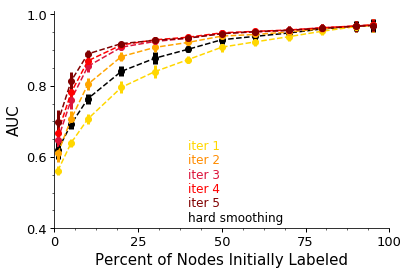

In [21]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter

fig = plt.figure()
#seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')
for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.4, 0.5,0.6,0.7,0.8,0.9,1]))

        
        
                
        grid[i].errorbar(percent_initially_labelled*100,mean_wt_auc_zgl_amherst ,
            yerr=se_wt_auc_zgl_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=5, color='black') 

        

        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_two, 
            yerr=se_wt_auc_two, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='gold')

        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter2, 
            yerr=se_wt_auc_iter2, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='orange')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter3, 
            yerr=se_wt_auc_iter3, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='crimson')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter4, 
            yerr=se_wt_auc_iter4, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='red') 
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_iter5, 
            yerr=se_wt_auc_iter5, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='maroon') 
        
  
        grid[i].set_ylim(0.3,1.1)
        grid[i].set_xlim(0,101)
    
        grid[i].annotate('iter 1', xy=(40, 0.62), 
                  color='gold', alpha=1, size=12)
 
        grid[i].annotate('iter 2', xy=(40, 0.58), 
                 color='darkorange', alpha=1, size=12)
        grid[i].annotate('iter 3', xy=(40, 0.54), 
                 color='crimson', alpha=1, size=12)
        
        grid[i].annotate('iter 4', xy=(40, 0.50), 
                 color='red', alpha=1, size=12)

        grid[i].annotate('iter 5', xy=(40, 0.46), 
                 color='maroon', alpha=1, size=12)

        grid[i].annotate('hard smoothing', xy=(40, 0.42), 
                 color='black', alpha=1, size=12)        

        

        grid[i].set_ylim(0.4,1.01)
        grid[i].set_xlim(0,100)
                         
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=13)
        grid[i].tick_params(axis='both', which='minor', labelsize=13)
        grid[i].set_xlabel('Percent of Nodes Initially Labeled').set_fontsize(15)
        grid[i].set_ylabel('AUC').set_fontsize(15)

#plt.setp(ax1, xticks=[0,25, 50, 75, 100], xticklabels=['0', '25', '50', '75', '100'])
grid[0].set_xticks([0,25, 50, 75, 100])
grid[0].set_yticks([0.4,0.6,0.8,1])


grid[0].minorticks_on()
grid[0].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
#plt.show()
#pp = PdfPages('../../figures/Amherst_College_Inference.pdf')
#pp.savefig()
#pp.close()